# 📊 Análise de Dados - Case ELO

## Objetivo

Este notebook apresenta uma análise de dados abrangente para identificar localizações ideais para novos laboratórios médicos. Combinamos dados demográficos, econômicos e de desempenho de laboratórios existentes para criar um modelo de pontuação que identifica áreas com maior potencial de mercado.

**Principais descobertas:**
- A combinação de alta população, elevada proporção de idosos e poder aquisitivo substancial são fatores determinantes para o sucesso de laboratórios médicos
- Identificamos dois modelos de negócio predominantes: estratégia premium (alta margem) e estratégia de volume (alta rotatividade)
- As ZCTAs com maior potencial para novos laboratórios combinam características demográficas favoráveis com baixa concorrência atual

**Metodologia:** Nossa abordagem integra análise exploratória, visualização geoespacial, correlação estatística e um modelo de pontuação ponderado para identificar as melhores oportunidades de expansão.

## 1. Importar Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

## 2. Carregar Dados

Nesta seção, carregamos os dados necessários para a análise, incluindo informações demográficas, localização de laboratórios, dados econômicos, catálogo de exames e dados transacionais.

In [2]:
# Definir caminhos para os arquivos
path_demographics = r".\Dados\DemographicData_ZCTAs.csv"
path_labs = r".\Dados\df_geocode.csv"
path_households = r".\Dados\EconomicData_ZCTAs.csv"
path_catalog = r".\Dados\exams_data.csv"
path_services = r".\Dados\transactional_data.csv"

# Carregar bases de dados
df_demographics = pd.read_csv(path_demographics, index_col=0)
df_labs = pd.read_csv(path_labs, index_col=0)
df_households = pd.read_csv(path_households, index_col=0)
df_catalog = pd.read_csv(path_catalog)
df_services = pd.read_csv(path_services, delimiter=';')

## 3. Inspeção e Limpeza de Dados

Antes de realizar a análise, inspecionamos e limpamos os dados para garantir consistência e qualidade.

In [3]:
# Exibir informações básicas de cada dataset
for name, df in {'Demographics': df_demographics, 'Labs': df_labs, 'Households': df_households, 
                 'Catalog': df_catalog, 'Services': df_services}.items():
    print(f"--- {name} ---")
    display(df.head(2))
    print(f"Dimensões: {df.shape}, Tipos de dados: {df.dtypes.value_counts().to_dict()}\n")

--- Demographics ---


,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
0,8600000US35004,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5
1,8600000US35005,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0


Dimensões: (33120, 18), Tipos de dados: {dtype('int64'): 14, dtype('O'): 2, dtype('float64'): 2}

--- Labs ---


,Lab Id,Address,Location,Zipcode
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0


Dimensões: (119, 4), Tipos de dados: {dtype('O'): 3, dtype('float64'): 1}

--- Households ---


,id,Geographic Area Name,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
0,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61
1,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26


Dimensões: (629280, 12), Tipos de dados: {dtype('int64'): 10, dtype('O'): 2}

--- Catalog ---


,CodItem,Desc Item,Category,Family,Speciality,Testing Cost
0,70003237,"MAGNESIO, SORO (EXEMPLO DE EXPRESSAO DE RESULT...",CA,CORELAB,BIOCHEMISTRY,1.78
1,70000638,"HEMOGRAMA, AUTOMATIZADO, SANGUE",CA,HEMATO,BLOOD COUNT,2.46


Dimensões: (2002, 6), Tipos de dados: {dtype('O'): 4, dtype('int64'): 1, dtype('float64'): 1}

--- Services ---


,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70003237,"9,0"
1,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000638,"13,0"


Dimensões: (2355241, 8), Tipos de dados: {dtype('O'): 7, dtype('int64'): 1}



### 3.1 Padronização e Limpeza dos Dados

1. Padronização de nomes de colunas
2. Tratamento de duplicatas e valores nulos
3. Conversão de tipos de dados

#### Sobre Renomeação de Colunas

Na padronização dos dados, renomeamos algumas colunas importantes para garantir consistência e clareza:

- **`lab_id` → `lab_location_id`**: Esta mudança foi feita porque o dataframe `df_labs` contém informações sobre a localização física dos laboratórios, não sobre suas métricas de desempenho. Mais tarde, usaremos o `lab_id` original dos dados transacionais para análise de performance.

- **`id` → `geo_id`** nos dataframes demográficos e econômicos: Renomeamos para evitar ambiguidade, já que 'id' é um nome genérico. O prefixo 'geo_' deixa claro que este identificador se refere a uma região geográfica específica.

Estas alterações são importantes para evitar conflitos durante as operações de merge entre os diferentes conjuntos de dados.

In [4]:
# Função para limpar os nomes das colunas e tratar dados básicos
def preparar_dataframe(df, nome):
    # Padronizar nomes de colunas
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    
    # Remover duplicatas se existirem
    n_duplicatas = df.duplicated().sum()
    if n_duplicatas > 0:
        print(f"Removendo {n_duplicatas} duplicatas de {nome}")
        df = df.drop_duplicates()
        
    return df

# Aplicar função em todos os dataframes
df_demographics = preparar_dataframe(df_demographics, "demographics")
df_labs = preparar_dataframe(df_labs, "labs")
df_households = preparar_dataframe(df_households, "households")
df_catalog = preparar_dataframe(df_catalog, "catalog")
df_services = preparar_dataframe(df_services, "services")

# Renomear colunas específicas para maior clareza 
df_demographics = df_demographics.rename(columns={'id': 'geo_id'})
df_households = df_households.rename(columns={'id': 'geo_id'})
df_labs = df_labs.rename(columns={'lab_id': 'lab_location_id'})

Removendo 596160 duplicatas de households
Removendo 14519 duplicatas de services
Removendo 14519 duplicatas de services


#### Com base na análise acima, definimos as seguintes estratégias:
- **Dados Demográficos ("df_demographics"):** Em "sexratio(males_per_100_females)" e "medianageinyears" usaremos a imputação pela mediana, resistente a outliers, para preencher os valores numéricos.
- **Dados de Laboratórios ("df_labs"):** Há um laboratório ("lab_id = -2") com "zipcode" nulo, marcado como "Unavailable". Como é um caso isolado e não representa uma localização real, removeremos essa linha.
- **Dados de Serviços ("df_services"):** Existe um único registro de serviço para um paciente sem "date_of_birth". Como não podemos calcular a idade e é um caso isolado, removeremos essa linha.

In [5]:
# Tratar valores nulos
for col in ['sexratio(males_per_100_females)', 'medianageinyears']:
    if col in df_demographics.columns:
        df_demographics[col] = df_demographics[col].fillna(df_demographics[col].median())

df_labs = df_labs.dropna(subset=['zipcode'])

df_services = df_services.dropna(subset=['date_of_birth'])

In [6]:
# Converter valores de custo de teste de string para float
# Substituir vírgulas por pontos para representação decimal
df_services['testing_cost'] = df_services['testing_cost'].str.replace(',', '.').astype(float)

# Verificar se a conversão foi bem-sucedida
print("Tipos de dados após conversão:")
print(df_services.dtypes)

Tipos de dados após conversão:
patient_id          object
gender              object
date_of_birth       object
date_of_service     object
service_id          object
lab_id              object
coditem              int64
testing_cost       float64
dtype: object


## 3.2 Preparação para Análise: Extração de ZCTA

As ZCTAs (ZIP Code Tabulation Areas) são unidades geográficas estatísticas desenvolvidas pelo Census Bureau dos EUA para facilitar a análise de dados demográficos e socioeconômicos. Nesta etapa, extraímos os códigos ZCTA dos nomes geográficos completos para permitir a junção (merge) com outros conjuntos de dados.

Usamos expressões regulares (regex) com o padrão `ZCTA5 (\d+)` para capturar apenas o código numérico de interesse. Esta padronização é essencial para vincular corretamente os dados demográficos e econômicos com os dados dos laboratórios em etapas futuras.

In [7]:
# Extrair ZCTAs dos nomes geográficos
df_households['zcta'] = df_households['geographic_area_name'].str.extract(r'ZCTA5 (\d+)').astype(str)
df_demographics['zcta'] = df_demographics['geographicareaname'].str.extract(r'ZCTA5 (\d+)').astype(str)

# Verificar amostra do resultado da extração
pd.DataFrame({
    'households_zcta': df_households['zcta'].head(3),
    'demographics_zcta': df_demographics['zcta'].head(3)
})

,households_zcta,demographics_zcta
0,35004,35004
1,35005,35005
2,35006,35006


## 4. Análise do Desempenho dos Laboratórios

Nesta seção, analisamos o desempenho dos laboratórios existentes com base no volume de exames realizados e na receita gerada.

### 4.1 Detalhamento da Análise de Performance

Nesta etapa, agregamos os dados de serviços por laboratório para criar métricas-chave de desempenho:

- **num_exams**: Contagem de exames realizados (count de service_id), indicando volume operacional
- **total_revenue**: Soma dos custos de teste, representando a receita bruta gerada
- **unique_patients**: Número de pacientes únicos atendidos (nunique de patient_id)
- **avg_cost**: Custo médio por exame (mean de testing_cost)

Também vinculamos o código postal (zipcode) a cada laboratório para posteriores análises geográficas. Esta etapa é fundamental para categorizar os diferentes modelos de negócio dos laboratórios e identificar as estratégias mais bem-sucedidas.

In [8]:
# Análise agregada por laboratório
lab_performance = df_services.groupby('lab_id').agg(
    num_exams=('service_id', 'count'),
    total_revenue=('testing_cost', 'sum'),
    unique_patients=('patient_id', 'nunique'),
    avg_cost=('testing_cost', 'mean')
).reset_index()

# Adicionar informações de localização 
lab_zipcode_map = dict(zip(df_labs['lab_location_id'], df_labs['zipcode']))
lab_performance['zipcode'] = lab_performance['lab_id'].map(lab_zipcode_map)

# Top laboratórios por volume de exames
display(lab_performance.sort_values('num_exams', ascending=False).head(5))

,lab_id,num_exams,total_revenue,unique_patients,avg_cost,zipcode
28,L133,121886,9711866.14,29454,79.679915,94565.0
41,L152,95255,6216304.62,22035,65.259615,30096.0
32,L139,93495,8778103.04,21976,93.888476,95823.0
19,L121,88430,6521202.54,18863,73.744233,98008.0
55,L166,76159,4721055.04,19065,61.989457,19120.0


### 4.2 Gráfico de Barras: Volume de Exames por Laboratório

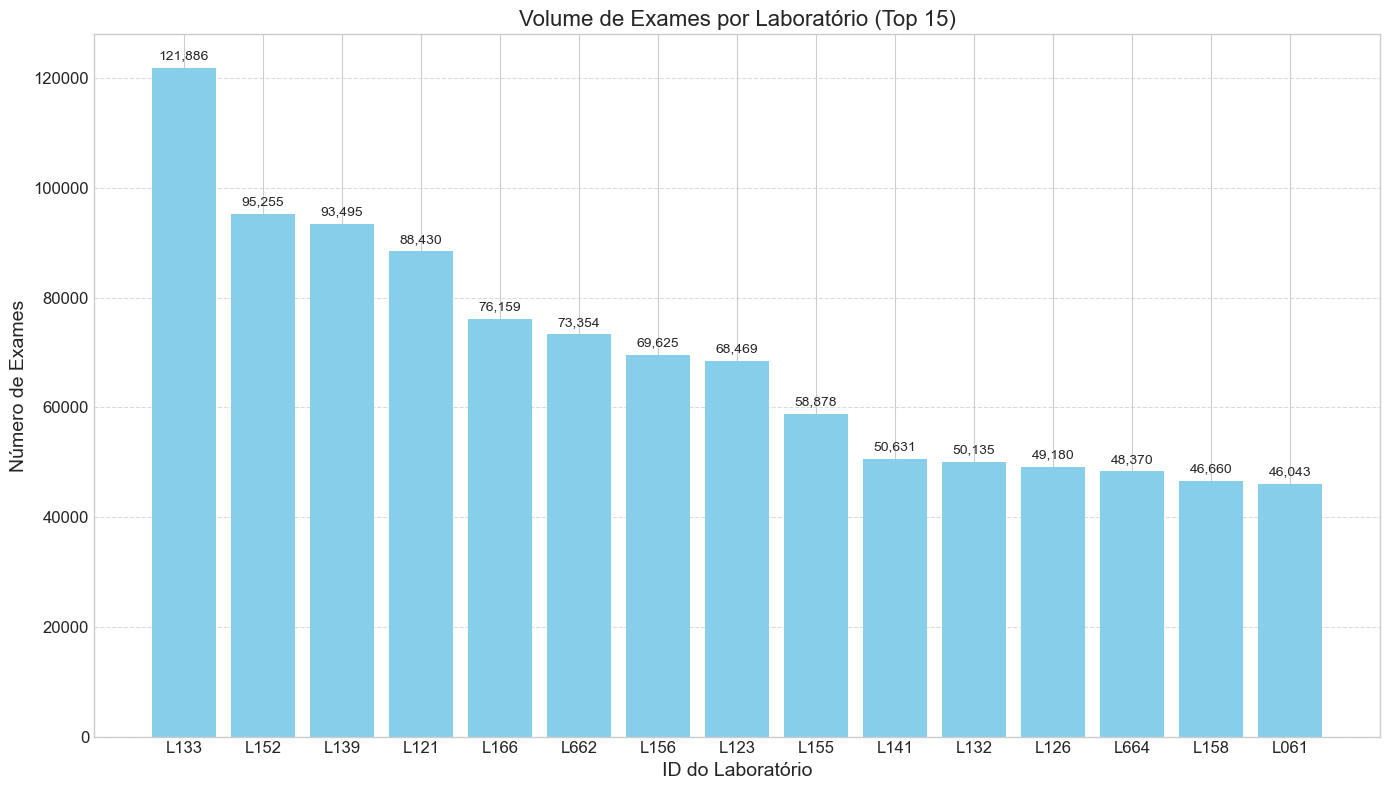

In [9]:
# Ordenar laboratórios por volume de exames e limitar para os 15 maiores
lab_performance_sorted = lab_performance.sort_values('num_exams', ascending=False).head(15)

# Criar gráfico de barras
plt.figure(figsize=(14, 8))
bars = plt.bar(lab_performance_sorted['lab_id'], lab_performance_sorted['num_exams'], color='skyblue')

# Adicionar rótulos de valores acima das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10)

# Configurar o gráfico
plt.title('Volume de Exames por Laboratório (Top 15)', fontsize=16)
plt.xlabel('ID do Laboratório', fontsize=14)
plt.ylabel('Número de Exames', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar layout
plt.tight_layout()
plt.show()

### 4.3 Normalização de Métricas de Desempenho

Para facilitar comparações justas entre laboratórios de diferentes tamanhos e regiões, aplicamos a normalização MinMax às principais métricas de desempenho. Isso escala todas as métricas para o intervalo [0,1], onde 0 representa o valor mínimo e 1 representa o valor máximo observado.

### Justificativa dos Pesos na Pontuação de Desempenho

Na criação da pontuação composta de desempenho, atribuímos pesos diferentes a cada métrica com base na sua importância relativa para o negócio:

- **Volume de Exames (40%)**: Recebeu o maior peso por ser um indicador direto da capacidade operacional e participação de mercado do laboratório. Maior volume geralmente significa maior capacidade de diluição de custos fixos.

- **Receita Total (30%)**: O segundo critério mais importante, pois representa o desempenho financeiro bruto do laboratório e sua capacidade de geração de caixa.

- **Pacientes Únicos (20%)**: Reflete o alcance do laboratório na população e seu potencial para crescimento via fidelização e vendas cruzadas.

- **Custo Médio (10%)**: Recebeu o menor peso pois, embora seja importante para identificar o posicionamento estratégico do laboratório (premium vs. volume), não necessariamente determina o sucesso do negócio por si só.

Esta distribuição de pesos permite identificar laboratórios que conseguem equilibrar volume, receita e base de clientes, independentemente do modelo de negócio adotado (premium ou volume).

In [10]:
# Definir métricas para normalização
performance_metrics = ['num_exams', 'total_revenue', 'unique_patients', 'avg_cost']

# Criar cópia para evitar alterações nos dados originais
lab_performance_scaled = lab_performance.copy()

# Aplicar MinMaxScaler em cada métrica
scaler = MinMaxScaler()
lab_performance_scaled[performance_metrics] = scaler.fit_transform(lab_performance[performance_metrics])

# Calcular pontuação composta (com pesos personalizáveis)
weights = {
    'num_exams': 0.4,      # Volume é importante para capacidade
    'total_revenue': 0.3,  # Receita reflete desempenho financeiro
    'unique_patients': 0.2, # Alcance na população
    'avg_cost': 0.1        # Estratégia de preços (peso menor)
}

# Calcular pontuação total ponderada
lab_performance_scaled['performance_score'] = sum(
    lab_performance_scaled[metric] * weight 
    for metric, weight in weights.items()
)

# Identificar os laboratórios com melhor desempenho geral
top_performers = lab_performance_scaled.sort_values('performance_score', ascending=False).head(10)

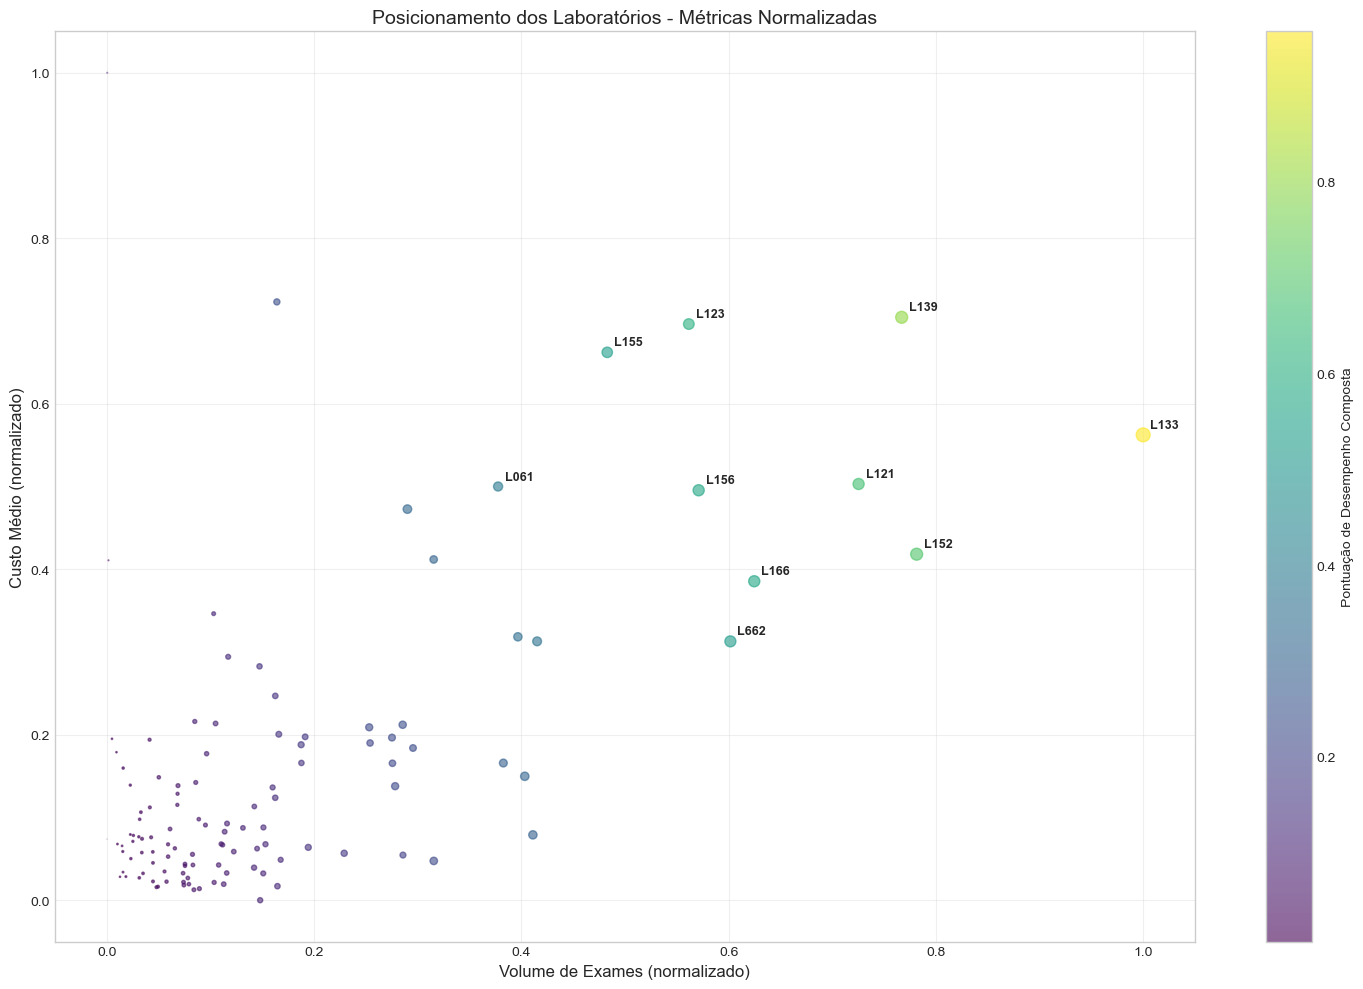

In [11]:
# Visualizar distribuição das métricas normalizadas
plt.figure(figsize=(15, 10))

# Gráfico de dispersão com rótulos para os melhores laboratórios
plt.scatter(lab_performance_scaled['num_exams'], 
            lab_performance_scaled['avg_cost'],
            c=lab_performance_scaled['performance_score'],
            s=lab_performance_scaled['unique_patients']*100,
            alpha=0.6, cmap='viridis')

# Adicionar rótulos apenas para os top performers
for _, row in top_performers.iterrows():
    plt.annotate(row['lab_id'], 
                (row['num_exams'], row['avg_cost']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold')

plt.colorbar(label='Pontuação de Desempenho Composta')
plt.xlabel('Volume de Exames (normalizado)', fontsize=12)
plt.ylabel('Custo Médio (normalizado)', fontsize=12)
plt.title('Posicionamento dos Laboratórios - Métricas Normalizadas', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 Análise de Estratégias de Negócio

Com base nas métricas normalizadas, podemos identificar claramente diferentes estratégias de negócio entre os laboratórios:

- **Líderes de Volume (alto volume + baixo custo)**: Laboratórios como L152 e L132 adotam uma estratégia de alto volume com preços mais acessíveis, buscando maximizar o número de exames realizados.

- **Especialistas Premium (custo alto + volume moderado)**: Laboratórios como L133, L139 e L123 praticam preços mais elevados, possivelmente focando em exames de maior complexidade ou atendimento diferenciado.

- **Generalistas Balanceados**: Laboratórios como L166 e L156 mantêm um equilíbrio entre volume e preço, com desempenho sólido em todas as métricas.

A pontuação composta nos permite identificar os laboratórios que conseguem otimizar melhor todas as dimensões de desempenho, considerando os diferentes pesos atribuídos a cada métrica.

### 4.5 Mapa Geográfico: Localização dos Laboratórios

Este mapa utiliza `geopandas` para exibir a localização dos laboratórios, com o tamanho dos pontos representando o volume de exames realizados.

In [12]:
# Corrigir criação do mapa geográfico
if 'latitude' not in df_labs.columns or 'longitude' not in df_labs.columns:
    df_labs[['latitude', 'longitude']] = df_labs['location'].str.split(',', expand=True).astype(float)

# Criar geometria dos pontos
geometry = [Point(xy) for xy in zip(df_labs['longitude'], df_labs['latitude'])]
gdf_labs = gpd.GeoDataFrame(df_labs, geometry=geometry)

# Adicionar volume de exames ao GeoDataFrame
gdf_labs = gdf_labs.merge(lab_performance[['lab_id', 'num_exams']], 
                        left_on='lab_location_id', right_on='lab_id', how='left')

# Remover linhas sem coordenadas ou volume de exames
gdf_labs = gdf_labs.dropna(subset=['latitude', 'longitude', 'num_exams'])

# Criar mapa interativo com Plotly
fig = px.scatter_mapbox(gdf_labs,
                     lat='latitude',
                     lon='longitude',
                     size='num_exams',
                     hover_name='lab_id',
                     size_max=30,
                     zoom=3,
                     height=700,
                     title='Localização dos Laboratórios por Volume de Exames')

fig.update_layout(mapbox_style='carto-positron')
fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 0})
fig.show()

### 4.6 Análise de Métricas-Chave de Performance

Para avaliar adequadamente o desempenho dos laboratórios, consideramos as seguintes métricas essenciais:

- **Volume de Exames (num_exams)**: Representa a capacidade operacional e a participação de mercado do laboratório
- **Receita Total (total_revenue)**: Indica o faturamento gerado pelos serviços prestados
- **Pacientes Únicos (unique_patients)**: Representa o alcance do laboratório na população
- **Custo Médio por Exame (avg_cost)**: Reflete a estratégia de preços e posicionamento de mercado
- **Receita por Paciente**: Calcula-se dividindo a receita total pelo número de pacientes únicos, indicando o valor médio que cada paciente gera para o laboratório

Estas métricas permitem identificar diferentes estratégias de negócio entre os laboratórios. Por exemplo, alguns laboratórios focam em alto volume com margens menores, enquanto outros priorizam exames especializados de maior valor.

### 4.7 Comparação de Desempenho dos Principais Laboratórios

Vamos comparar os principais laboratórios em termos de volume de exames, receita média por paciente e custo médio dos exames.

In [13]:
# Adicionar métricas para os top 15 laboratórios
top_labs = lab_performance_sorted.copy()
top_labs['revenue_per_patient'] = top_labs['total_revenue'] / top_labs['unique_patients']

# Criar gráfico de comparação interativo
fig = px.scatter(top_labs,
                x='num_exams', 
                y='avg_cost',
                size='unique_patients', 
                color='revenue_per_patient',
                hover_name='lab_id',
                log_x=True,
                size_max=45,
                color_continuous_scale='viridis',
                title='Comparação dos Principais Laboratórios')

fig.update_layout(height=600, width=900,
                 xaxis_title='Volume de Exames (log)',
                 yaxis_title='Custo Médio do Exame ($)',
                 coloraxis_colorbar_title='Receita por Paciente ($)')

fig.show()

## 5. Análise Demográfica e Econômica

Nesta seção, analisamos as características demográficas e econômicas das regiões para identificar áreas com potencial para novos laboratórios. A análise considera:

- **População total**: Representa o tamanho do mercado potencial
- **Proporção de idosos**: População com maior demanda por exames laboratoriais
- **Nível de renda**: Impacta diretamente o poder aquisitivo e capacidade de pagamento
- **Densidade de laboratórios existentes**: Indica o nível de competição na região

In [14]:
# Combinar dados demográficos e econômicos
demographics_econ = pd.merge(
    df_demographics,
    df_households,
    on=['geo_id', 'zcta'],
    how='inner'
)

# Calcular indicadores econômicos e demográficos
# 1. Identificar colunas por faixa de renda
household_cols = [col for col in demographics_econ.columns if 'totalhouseholds_' in col]
demographics_econ['total_households'] = demographics_econ[household_cols].sum(axis=1)

# 2. Indicadores de renda
high_income_cols = [col for col in household_cols if any(x in col for x in ['$100.000', '$150.000', '$200.000'])]
low_income_cols = [col for col in household_cols if any(x in col for x in ['lessthan$10.000', '$10.000to$14.999', '$15.000to$24.999'])]

demographics_econ['high_income_ratio'] = demographics_econ[high_income_cols].sum(axis=1) / demographics_econ['total_households']
demographics_econ['low_income_ratio'] = demographics_econ[low_income_cols].sum(axis=1) / demographics_econ['total_households']

# 3. Proporção de idosos e densidade populacional
elderly_cols = ['population_65to74years', 'population_75to84years', 'population_85yearsandover']
demographics_econ['elderly_ratio'] = demographics_econ[elderly_cols].sum(axis=1) / demographics_econ['totalpopulation']
demographics_econ['people_per_household'] = demographics_econ['totalpopulation'] / demographics_econ['total_households']

### 5.1 Correlação entre Indicadores Demográficos e Econômicos

O mapa de calor abaixo mostra as correlações entre os principais indicadores demográficos e econômicos. Observações importantes:

1. **População e Domicílios**: Forte correlação positiva (0.98), o que é esperado
2. **Renda Alta e População**: Correlação positiva moderada (0.23), sugerindo que áreas populosas tendem a ter maior proporção de famílias de alta renda
3. **Renda Baixa e Renda Alta**: Correlação negativa forte (-0.59), confirmando que estas são características mutuamente exclusivas de uma região
4. **Idade Mediana e Idosos**: Correlação positiva forte (0.74), indicando que áreas com população mais velha têm maior proporção de idosos
5. **Pessoas por Domicílio**: Baixa correlação com outros fatores, sugerindo que este indicador varia independentemente da renda ou idade

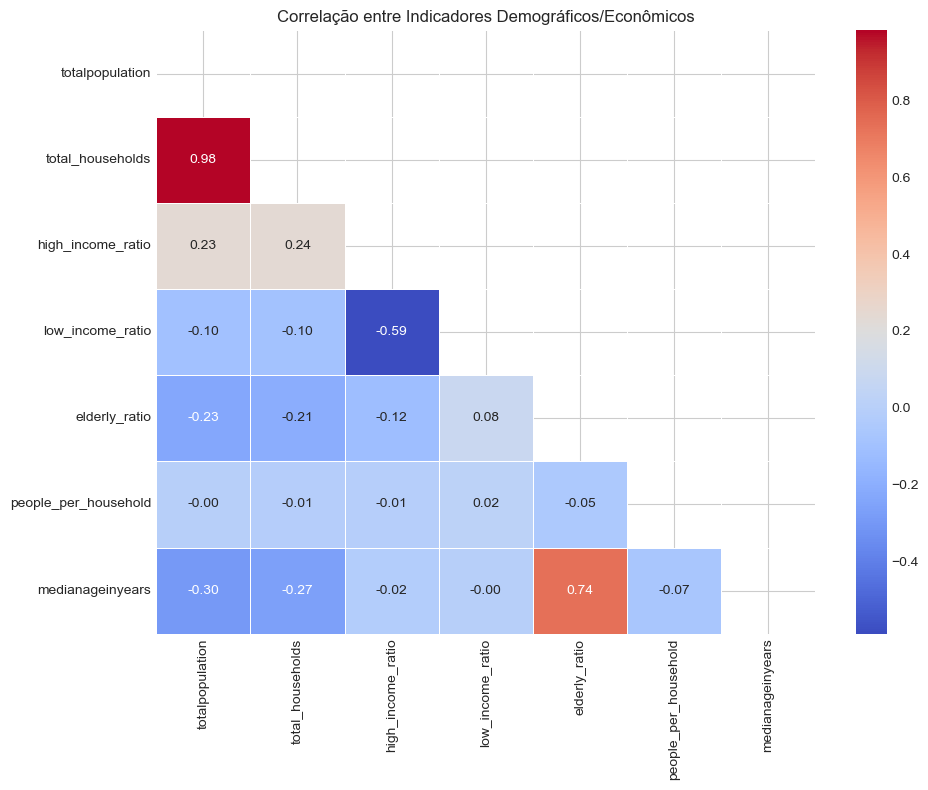

In [15]:
# Indicadores principais - análise de correlação
key_indicators = ['totalpopulation', 'total_households', 'high_income_ratio',
                  'low_income_ratio', 'elderly_ratio', 'people_per_household', 'medianageinyears']

# Visualizar correlação
plt.figure(figsize=(10, 8))
corr = demographics_econ[key_indicators].corr()
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlação entre Indicadores Demográficos/Econômicos')
plt.tight_layout()
plt.show()

## 6. Relação entre Demografia e Desempenho dos Laboratórios

Nesta seção, conectamos as características demográficas das áreas com o desempenho dos laboratórios. É fundamental garantir a compatibilidade dos tipos de dados para realizar os merges corretamente.

### Compatibilização de Tipos para Merge de Dados Geográficos

Esta etapa é crucial para a integração correta dos dados demográficos com os dados de desempenho dos laboratórios. A compatibilização de tipos enfrentou dois desafios principais:

1. **Zipcodes como Inteiros vs. ZCTAs como Strings**: Os códigos postais estavam armazenados como números inteiros no dataframe de laboratórios, enquanto as ZCTAs nos dados demográficos eram strings. Para permitir a junção correta, convertemos ambos para o mesmo formato string.

2. **Tratamento de Valores Nulos**: Alguns laboratórios não possuíam código postal válido. Utilizamos `fillna('0')` antes da conversão para evitar erros de tipo e possibilitar o processamento de todos os registros.

O uso do sufixo `_str` na nova coluna (`zipcode_str`) mantém a coluna original intacta, permitindo rastreabilidade e evitando problemas em análises posteriores. Essa prática de manter os dados originais enquanto criamos versões transformadas é considerada uma boa prática em análise de dados.

In [16]:
# Garantir compatibilidade dos tipos de dados para o merge
# Convertendo zipcode para string em lab_performance
lab_performance['zipcode_str'] = lab_performance['zipcode'].fillna('0').astype(int).astype(str)
# Garantir que zcta seja string
demographics_econ['zcta'] = demographics_econ['zcta'].astype(str)

# Relacionar dados de laboratórios com características demográficas usando as colunas de string
lab_zcta = pd.merge(
    lab_performance,
    demographics_econ[['zcta', 'totalpopulation', 'total_households', 
                      'high_income_ratio', 'low_income_ratio', 'elderly_ratio', 'medianageinyears']],
    left_on='zipcode_str',
    right_on='zcta',
    how='left'
)

# Calcular métricas de eficiência
lab_zcta['exams_per_capita'] = lab_zcta['num_exams'] / lab_zcta['totalpopulation']
lab_zcta['revenue_per_capita'] = lab_zcta['total_revenue'] / lab_zcta['totalpopulation']

# Remover linhas com dados demográficos ausentes
lab_zcta_clean = lab_zcta.dropna(subset=['totalpopulation'])

print(f"Laboratórios com dados demográficos vinculados: {len(lab_zcta_clean)} de {len(lab_performance)}")

Laboratórios com dados demográficos vinculados: 95 de 118


### 6.1 Interpretação dos Gráficos de Dispersão

A análise dos gráficos revela relações importantes entre características demográficas e desempenho dos laboratórios:

**Receita vs. População Total:**
- Relação positiva entre população e receita total, com significativa dispersão
- Alguns laboratórios mostram bom desempenho mesmo em áreas menos populosas

**Receita per Capita vs. Alta Renda:**
- Maior receita per capita em áreas de alta renda
- Laboratórios em áreas ricas praticam preços mais elevados

**Receita per Capita vs. Idosos:**
- Forte correlação positiva entre proporção de idosos e receita per capita
- Áreas com população mais idosa representam mercados mais lucrativos

**Custo Médio vs. Baixa Renda:**
- Tendência de preços menores em áreas de baixa renda
- Laboratórios adaptam sua estratégia ao poder aquisitivo local

**Conclusão:** Identificamos dois modelos de negócio predominantes:
- **Estratégia Premium:** Custos elevados em áreas ricas/idosas, alta receita per capita
- **Estratégia de Volume:** Preços acessíveis em áreas de menor renda, compensando com volume

### 6.2 Análise dos Três Melhores Laboratórios

Para compreender melhor as estratégias de negócio mais bem-sucedidas, analisamos em detalhe os três laboratórios com maior volume de exames. Esta análise nos permite:

1. **Comparar diferentes modelos de negócio**: O contraste entre as métricas dos três laboratórios revela diferentes abordagens estratégicas (volume vs. premium).

2. **Identificar métricas-chave diferenciadoras**: Além do volume de exames, indicadores como receita por paciente e exames por paciente fornecem insights sobre o perfil de serviço e a eficiência operacional.

3. **Balancear as métricas para comparação visual**: A normalização usando MinMaxScaler permite visualizar todas as métricas na mesma escala, facilitando a comparação direta entre laboratórios independentemente das magnitudes absolutas.

Esta análise comparativa é crucial para identificar as melhores práticas que podem ser replicadas em novos laboratórios, respeitando as características demográficas e econômicas de cada localidade.

Análise Detalhada dos 3 Laboratórios com Melhor Desempenho:


,Total de Exames,Receita Total,Pacientes Únicos,Custo Médio por Exame,Receita por Paciente,Exames por Paciente
28,"121,886","$9,711,866.14","29,454",$79.68,$329.73,4.1
41,"95,255","$6,216,304.62","22,035",$65.26,$282.11,4.3
32,"93,495","$8,778,103.04","21,976",$93.89,$399.44,4.3


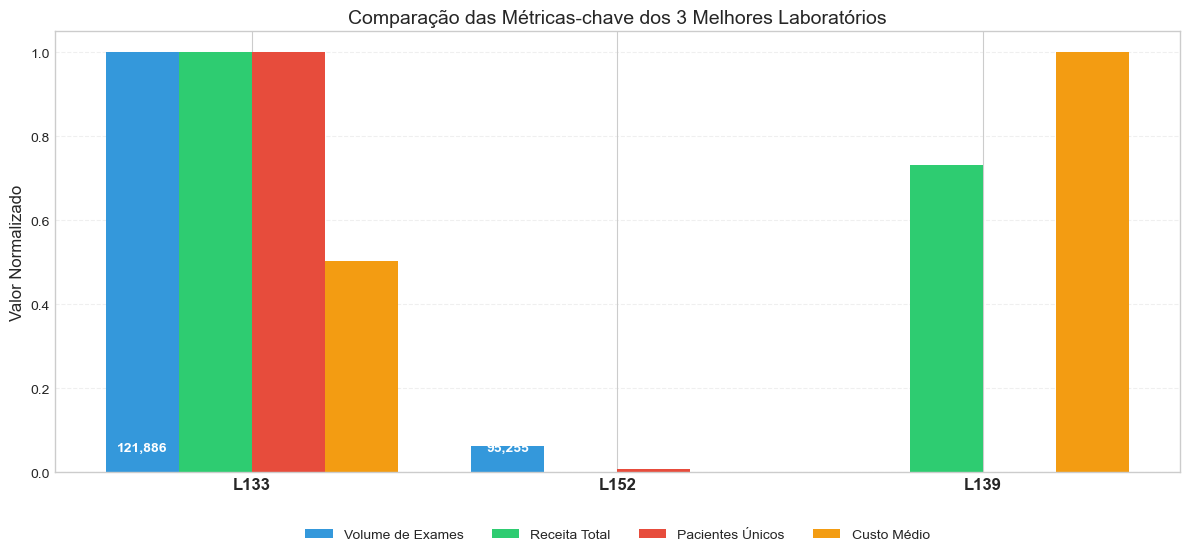

In [17]:
# Extrair e formatar informações detalhadas dos 3 melhores laboratórios
top3_labs = lab_performance.sort_values('num_exams', ascending=False).head(3)

# Adicionar métricas complementares
top3_labs['revenue_per_patient'] = top3_labs['total_revenue'] / top3_labs['unique_patients']
top3_labs['exams_per_patient'] = top3_labs['num_exams'] / top3_labs['unique_patients']

# Formatar os valores para melhor visualização
top3_labs_display = pd.DataFrame({
    'Total de Exames': top3_labs['num_exams'].map('{:,.0f}'.format),
    'Receita Total': top3_labs['total_revenue'].map('${:,.2f}'.format),
    'Pacientes Únicos': top3_labs['unique_patients'].map('{:,.0f}'.format),
    'Custo Médio por Exame': top3_labs['avg_cost'].map('${:.2f}'.format),
    'Receita por Paciente': top3_labs['revenue_per_patient'].map('${:.2f}'.format),
    'Exames por Paciente': top3_labs['exams_per_patient'].map('{:.1f}'.format)
})

print("Análise Detalhada dos 3 Laboratórios com Melhor Desempenho:")
display(top3_labs_display)

# Criar gráfico comparativo de barras múltiplas
plt.figure(figsize=(12, 6))

# Definir posições das barras
labs = top3_labs.index
lab_ids = top3_labs['lab_id']
x = np.arange(len(lab_ids))
width = 0.2

# Normalizar métricas para comparabilidade no gráfico
metrics = ['num_exams', 'total_revenue', 'unique_patients', 'avg_cost']
scaler = MinMaxScaler()
top3_normalized = pd.DataFrame(scaler.fit_transform(top3_labs[metrics]), 
                              columns=metrics, 
                              index=top3_labs.index)

# Plotar múltiplas barras
plt.bar(x - width*1.5, top3_normalized['num_exams'], width, label='Volume de Exames', color='#3498db')
plt.bar(x - width/2, top3_normalized['total_revenue'], width, label='Receita Total', color='#2ecc71')
plt.bar(x + width/2, top3_normalized['unique_patients'], width, label='Pacientes Únicos', color='#e74c3c')
plt.bar(x + width*1.5, top3_normalized['avg_cost'], width, label='Custo Médio', color='#f39c12')

# Configurar o gráfico
plt.xticks(x, lab_ids, fontsize=12, fontweight='bold')
plt.title('Comparação das Métricas-chave dos 3 Melhores Laboratórios', fontsize=14)
plt.ylabel('Valor Normalizado', fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

# Adicionar textos nas barras do volume de exames
for i, v in enumerate(top3_labs['num_exams']):
    plt.text(i - width*1.5, 0.05, f"{int(v):,}", 
            color='white', fontweight='bold', ha='center')

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Ajustar para acomodar a legenda
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

## 7. Conclusões e Recomendações

Com base nas análises realizadas, destacamos os seguintes insights chave:

1. **Top 3 Laboratórios por Desempenho:**
   - **L133:** Líder absoluto com 121.886 exames e receita de $9.711.866,14, atendeu 29.454 pacientes com custo médio por exame de $79,68
   - **L139:** Apresenta a maior receita por paciente ($399,44) com 93.495 exames e custo médio elevado de $93,89
   - **L152:** Segundo maior em volume com 95.255 exames, receita de $6.216.304,62 e estratégia de preço intermediário ($65,26)

2. **Modelos de Negócio Identificados:**
   - **Premium (L133, L139, L123):** Alto custo médio (>$79) e elevada receita por paciente
   - **Volume (L152, L662, L132):** Preços mais acessíveis e alto volume de atendimentos
   - **Balanceados (L166, L156):** Equilíbrio entre preço e volume

3. **Correlações Demográficas:** População idosa tem forte correlação positiva (0.74) com a mediana de idade, sugerindo priorização de áreas com alta concentração de idosos.

4. **Potencial de Mercado:** Áreas com alto potencial combinam:
   - Alta população total
   - Alta porcentagem de idosos
   - Domicílios de alta renda
   - Baixa presença de laboratórios
   - Baixo número de exames per capita

5. **Recomendações para Novos Laboratórios:**
   - Priorizar top ZCTAs identificadas na análise
   - Focar em regiões com população idosa
   - Adaptar mix de exames às necessidades locais
   - Desenvolver estratégias de preços segmentadas

6. **Próximos Passos:**
   - Pesquisas de mercado nas áreas de alto potencial
   - Análise de sazonalidade da demanda
   - Parcerias estratégicas com clínicas médicas locais

**Limitações da Análise:**
- Granularidade geográfica: ZCTAs podem mascarar variações locais
- Dados temporais: Baseado em histórico, sem capturar tendências emergentes
- Fatores não quantificados: Acessibilidade, visibilidade e proximidade a centros médicos

**Refinamentos Futuros:**
1. Estudos de viabilidade nas ZCTAs de maior potencial
2. Segmentação de clientes por região prioritária
3. Mapeamento competitivo em áreas-alvo
4. Implementação de laboratórios-piloto em locais estratégicos